## Classification with Scikit Learn (Trees & Forests) - Part 2


Data Source adapted from
https://data.world/uci/bank-marketing/workspace/file?filename=bank-additional%2Fbank-additional-names.txt

### 1. Load into pd.DataFrame

In [2]:
import pandas as pd 

df = pd.read_csv("data/bank_data.csv", delimiter=";")

del df["campaign"]  #info not available at the time of prediction
del df["duration"] #info not available at the time of prediction

print(len(df))
df.head()

41188


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [3]:
import numpy as np

df.replace("unknown", np.nan, inplace=True)
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,NaN,no,no,telephone,may,mon,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [4]:
#Handle default (see previous notebook)
df["default"] = df["default"].fillna("unknown")
df = df[df["default"] != "yes"]
df["default"].value_counts(dropna=False)

no         32588
unknown     8597
Name: default, dtype: int64

### Got some new attributes! 

#### Campaign Data
- 11 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
- 12 - previous: number of contacts performed before this campaign and for this client (numeric)
- 13 - poutcome: outcome of the previous marketing campaign (categorical: "failure","nonexistent","success")

#### Social and economic context attributes
- 14 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
- 15 - cons.price.idx: consumer price index - monthly indicator (numeric)     
- 16 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)     
- 17 - euribor3m: euribor 3 month rate - daily indicator (numeric)
- 18 - nr.employed: number of employees - quarterly indicator (numeric)

### 2. Exploration 

In [5]:
#Pdays Explore
import matplotlib.pyplot as plt 
%matplotlib inline 

print(df["pdays"].value_counts(dropna=False))
print(type(df["pdays"].iloc[10]))

999    39670
3        439
6        412
4        118
9         64
2         61
7         60
12        58
10        52
5         46
13        36
11        28
1         26
15        24
14        20
8         18
0         15
16        11
17         8
18         7
19         3
22         3
21         2
26         1
20         1
25         1
27         1
Name: pdays, dtype: int64
<class 'numpy.int64'>


In [6]:
#Pdays Replace for Forests 
df.replace(999, -1, inplace=True)
print(df["pdays"].value_counts(dropna=False))

-1     39670
 3       439
 6       412
 4       118
 9        64
 2        61
 7        60
 12       58
 10       52
 5        46
 13       36
 11       28
 1        26
 15       24
 14       20
 8        18
 0        15
 16       11
 17        8
 18        7
 19        3
 22        3
 21        2
 27        1
 20        1
 25        1
 26        1
Name: pdays, dtype: int64


In [7]:
#Value Counts Check
df["previous"].value_counts(dropna=False)

0    35561
1     4560
2      754
3      216
4       70
5       18
6        5
7        1
Name: previous, dtype: int64

In [8]:
df["poutcome"].value_counts(dropna=False)

nonexistent    35561
failure         4251
success         1373
Name: poutcome, dtype: int64

**-> Make this check with every variable!**

In [9]:
#Convert Month & Day to Integers 
d1 = {'jan':1, 'feb':2, 'mar':3, 'apr':4, 'may':5, 'jun':6, 'jul':7, 'aug':8, 'sep':9, 'oct':10, 'nov':11,'dec':12}
d2 = {'mon': 1, 'tue': 2, 'wed': 3, 'thu': 4, 'fri': 5}

df["month"] = df["month"].map(d1)
df["day_of_week"] = df["day_of_week"].map(d2)
df.month.head()

0    5
1    5
2    5
3    5
4    5
Name: month, dtype: int64

In [10]:
#Convert educational to ordinal scale (0-5)
d3 = {"illiterate": 0, 
      "basic.4y": 1, 
      "basic.6y": 2, 
      "basic.9y": 3, 
      "high.school": 4, 
      "professional.course": 5, 
      "university.degree": 6} 

df["education"] = df["education"].map(d3)
df["education"].head()

0    1.0
1    4.0
2    4.0
3    2.0
4    4.0
Name: education, dtype: float64

### 3. Dropping NaN

In [11]:
#Nulls 
for col in df.columns: 
    print("{}:".format(col), df[col].isnull().sum())

age: 0
job: 330
marital: 80
education: 1731
default: 0
housing: 990
loan: 990
contact: 0
month: 0
day_of_week: 0
pdays: 0
previous: 0
poutcome: 0
emp.var.rate: 0
cons.price.idx: 0
cons.conf.idx: 0
euribor3m: 0
nr.employed: 0
y: 0


In [12]:
df.dropna(inplace=True)
print(len(df))

38242


**--> New attributes and more data!**

### 4. Create Train/Test Set 

*Avoid Data Snooping Bias!*

In [13]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

lb = preprocessing.LabelBinarizer()
df["y_new"] = lb.fit_transform(df["y"])
X = df.iloc[:, :-2]
y = df["y_new"]

X, X_test, y, y_test = train_test_split(X, y, random_state=42)
print(len(X))
X.head()

28681


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
22807,35,management,married,6.0,no,no,yes,telephone,8,1,-1,0,nonexistent,1.4,93.444,-36.1,4.965,5228.1
25976,35,technician,single,3.0,no,yes,yes,cellular,11,3,-1,0,nonexistent,-0.1,93.200,-42.0,4.120,5195.8
35962,34,admin.,married,6.0,no,yes,no,cellular,5,1,-1,1,failure,-1.8,92.893,-46.2,1.264,5099.1
40130,29,blue-collar,single,2.0,no,yes,no,telephone,7,2,-1,0,nonexistent,-1.7,94.215,-40.3,0.835,4991.6
23292,44,technician,married,5.0,no,no,no,cellular,8,3,-1,0,nonexistent,1.4,93.444,-36.1,4.964,5228.1


In [14]:
print(len(y))
y.head()

28681


22807    0
25976    0
35962    0
40130    0
23292    0
Name: y_new, dtype: int64

### 6. Create a Pipeline for Decision Trees 

In [15]:
#Adapt Pipe (add "poutcome" to OneHot & extend "cat_unchanged")
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, LabelBinarizer
from sklearn_pandas import DataFrameMapper
from sklearn.pipeline import Pipeline, FeatureUnion

cat_unchanged = ["age", "education", "month", "day_of_week", "pdays", "previous", 
                 "emp.var.rate", "cons.price.idx", "cons.conf.idx", "euribor3m", "nr.employed"]
cat_1hot = ["job", "marital", "poutcome"]
cat_binary = ["default", "housing", "loan", "contact"]

#Pipeline 1
mapper1 = DataFrameMapper(
    [(d, LabelEncoder()) for d in cat_1hot]
)

onehot_pipe = Pipeline([
    ("mapper", mapper1),
    ("onehot", OneHotEncoder(sparse=False))
])

#Pipeline 2 (Binary + Features Unchanged)
mapper2 = DataFrameMapper(
    [(d, None) for d in cat_unchanged] +
    [(d, LabelBinarizer()) for d in cat_binary]
)

binary_pipe = Pipeline([
    ("mapper", mapper2)
])

#Full Pipeline
full_pipeline = FeatureUnion(transformer_list=[
        ("binary_pipe", binary_pipe),
        ("onehot_pipe", onehot_pipe)
    ])

X_prepared = full_pipeline.fit_transform(X)
X_prepared[:5]

array([[ 3.5000e+01,  6.0000e+00,  8.0000e+00,  1.0000e+00, -1.0000e+00,
         0.0000e+00,  1.4000e+00,  9.3444e+01, -3.6100e+01,  4.9650e+00,
         5.2281e+03,  0.0000e+00,  0.0000e+00,  1.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00],
       [ 3.5000e+01,  3.0000e+00,  1.1000e+01,  3.0000e+00, -1.0000e+00,
         0.0000e+00, -1.0000e-01,  9.3200e+01, -4.2000e+01,  4.1200e+00,
         5.1958e+03,  0.0000e+00,  1.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00],
       [ 3.4000e+01,  6.0000e+00,  5.0000e+00,  1.0000

In [16]:
#Make Training DF
cols = [cat_unchanged 
        +cat_binary[:-1] +["telephone"]
        +["job_" + l for l in list(np.sort(df["job"].unique()))] 
        +["divorced", "married", "single"] 
        +["poutcome_failure", "poutcome_nonexistent", "poutcome_success"]
       ]

X_final = pd.DataFrame(X_prepared, columns=cols)
X_final.tail(10)

,age,education,month,day_of_week,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,...,job_services,job_student,job_technician,job_unemployed,divorced,married,single,poutcome_failure,poutcome_nonexistent,poutcome_success
28671,38.0,3.0,5.0,5.0,-1.0,0.0,1.1,93.994,-36.4,4.855,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
28672,37.0,6.0,7.0,1.0,-1.0,0.0,1.4,93.918,-42.7,4.962,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
28673,50.0,3.0,8.0,4.0,-1.0,0.0,1.4,93.444,-36.1,4.962,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
28674,38.0,4.0,7.0,4.0,10.0,2.0,-1.7,94.215,-40.3,0.782,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
28675,58.0,1.0,7.0,4.0,-1.0,0.0,1.4,93.918,-42.7,4.968,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
28676,49.0,4.0,5.0,3.0,-1.0,0.0,1.1,93.994,-36.4,4.857,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
28677,41.0,1.0,7.0,5.0,-1.0,0.0,1.4,93.918,-42.7,4.959,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
28678,52.0,6.0,11.0,3.0,-1.0,1.0,-1.1,94.767,-50.8,1.048,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
28679,34.0,2.0,5.0,3.0,-1.0,0.0,1.1,93.994,-36.4,4.856,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
28680,58.0,5.0,7.0,5.0,-1.0,0.0,1.4,93.918,-42.7,4.962,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [17]:
#Make Testing DF
X_test_prepared = full_pipeline.fit_transform(X_test)
X_test_prepared = pd.DataFrame(X_test_prepared, columns=cols)
X_test_prepared.head()

,age,education,month,day_of_week,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,...,job_services,job_student,job_technician,job_unemployed,divorced,married,single,poutcome_failure,poutcome_nonexistent,poutcome_success
0,32.0,4.0,7.0,1.0,-1.0,0.0,1.4,93.918,-42.7,4.960,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,51.0,6.0,11.0,3.0,-1.0,1.0,-0.1,93.200,-42.0,4.120,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
2,46.0,3.0,5.0,2.0,-1.0,0.0,1.1,93.994,-36.4,4.857,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,38.0,4.0,5.0,2.0,-1.0,0.0,1.1,93.994,-36.4,4.857,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,35.0,3.0,5.0,2.0,-1.0,0.0,1.1,93.994,-36.4,4.856,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


### 7. Decision Trees

In [18]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import pydot
from IPython.display import Image

criteria = ["gini", "entropy"]

for c in criteria: 
    tree_clf = DecisionTreeClassifier(criterion=c, random_state=39)
    tree_clf.fit(X_final,y)
    y_pred_tree = tree_clf.predict(X_test_prepared)
    score = tree_clf.score(X_test_prepared, y_test)
    print("Score: {} = {}".format(c,score))
    
    export_graphviz(
        tree_clf,
        out_file = "output/tree_new.dot",
        feature_names = cols[0],
        class_names = ["No", "Yes"],
        max_depth = 5,
        filled=True)
    
    (graph,) = pydot.graph_from_dot_file('output/tree_new.dot')
    png = 'output/tree_new_{}.png'.format(c)
    graph.write_png(png) 

Score: gini = 0.8434264198305617
Score: entropy = 0.8424850957012865


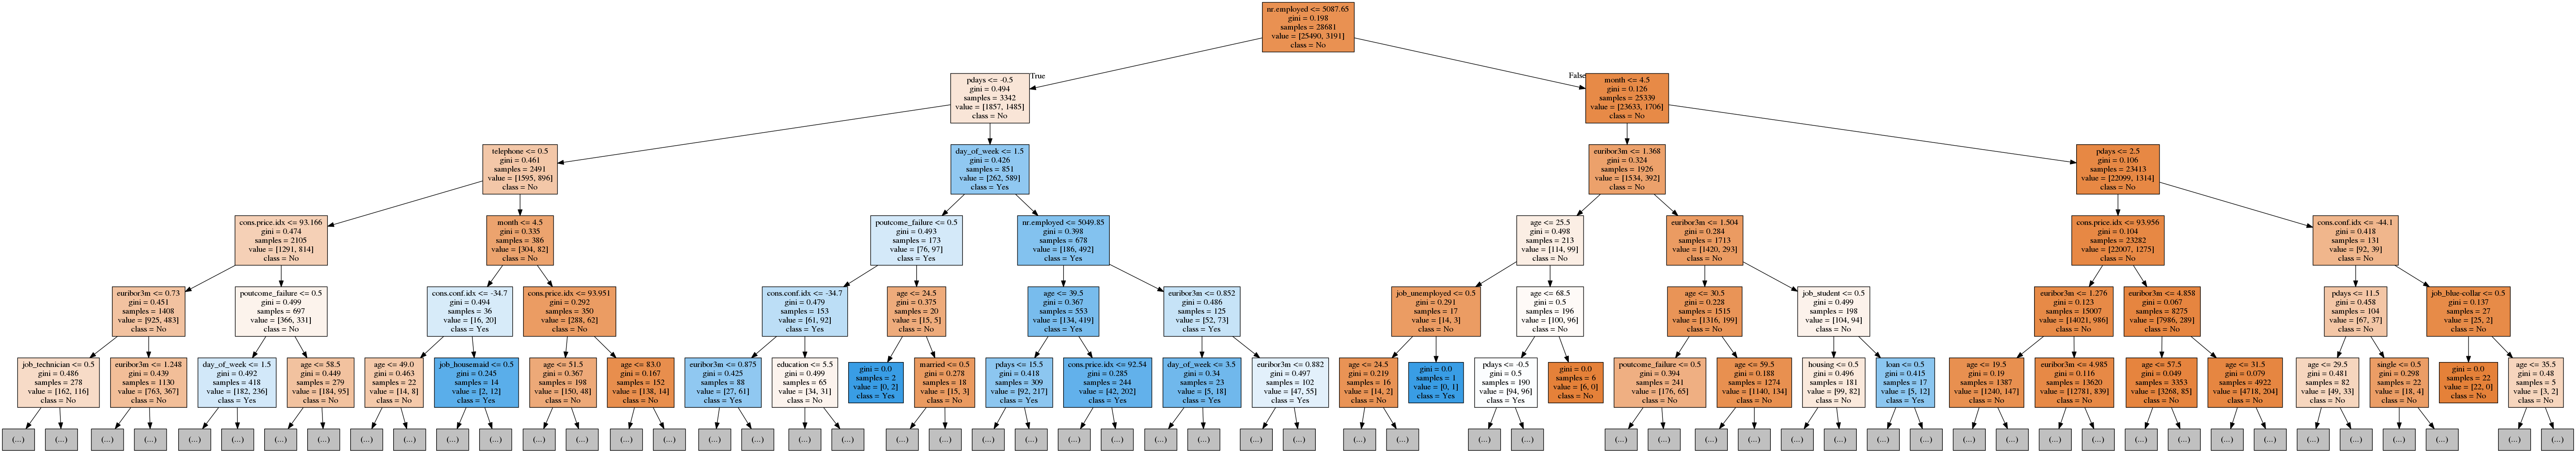

In [19]:
#Show Images 
Image("output/tree_new_gini.png")

In [21]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_pred_tree, y_test)
print(cm)

precision = cm[1,1]/(cm[0,1]+cm[1,1])
recall = cm[1,1]/(cm[1,0]+cm[1,1])
print("Precision: {}".format(precision))
print("Recall: {}".format(recall))
print("F1-Score: {}".format((recall*precision*2)/(recall+precision)))

[[7719  731]
 [ 775  336]]
Precision: 0.3149015932521087
Recall: 0.30243024302430244
F1-Score: 0.3085399449035813


### 8. Random Forest 

In [23]:
from sklearn.ensemble import RandomForestClassifier

for c in criteria: 
    forest_clf = RandomForestClassifier(n_estimators=30, criterion=c, random_state=42)
    forest_clf.fit(X_final,y)
    y_pred = forest_clf.predict(X_test_prepared)
    print("{}".format(c), forest_clf.score(X_test_prepared, y_test))

gini 0.8874594707666562
entropy 0.886518146637381


In [24]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_pred, y_test)
print(cm)

precision = cm[1,1]/(cm[0,1]+cm[1,1])
recall = cm[1,1]/(cm[1,0]+cm[1,1])
print("Precision: {}".format(precision))
print("Recall: {}".format(recall))
print("F1-Score: {}".format((recall*precision*2)/(recall+precision)))

[[8184  775]
 [ 310  292]]
Precision: 0.2736644798500469
Recall: 0.4850498338870432
F1-Score: 0.3499101258238467


**Lost precision, but increased recall.**

In [25]:
# Get numerical feature importances
importances = list(forest_clf.feature_importances_)
feature_importances = [(feature, round(importance, 3)) for feature, importance in zip(cols[0], importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True) 
feature_importances

[('age', 0.215),
 ('euribor3m', 0.152),
 ('education', 0.075),
 ('day_of_week', 0.072),
 ('nr.employed', 0.054),
 ('housing', 0.043),
 ('emp.var.rate', 0.04),
 ('cons.conf.idx', 0.029),
 ('poutcome_success', 0.026),
 ('loan', 0.025),
 ('month', 0.022),
 ('cons.price.idx', 0.019),
 ('default', 0.019),
 ('job_admin.', 0.019),
 ('pdays', 0.018),
 ('married', 0.018),
 ('telephone', 0.017),
 ('previous', 0.015),
 ('job_technician', 0.015),
 ('single', 0.015),
 ('job_blue-collar', 0.013),
 ('divorced', 0.012),
 ('job_management', 0.01),
 ('job_services', 0.01),
 ('job_retired', 0.007),
 ('job_self-employed', 0.007),
 ('job_entrepreneur', 0.006),
 ('job_unemployed', 0.006),
 ('poutcome_failure', 0.006),
 ('job_housemaid', 0.005),
 ('job_student', 0.005),
 ('poutcome_nonexistent', 0.004)]

### 9. Finetuning: Grid Search 

**!!! Beware of Scoring Function: Default = 'accuracy' !!!**

For Different Scoring Functions see http://scikit-learn.org/stable/modules/model_evaluation.html

F1 score? Can be interpreted as a weighted average of the precision and recall.

**F1 = 2 \* (precision * recall) / (precision + recall)**

In [123]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    # try 32 (2×2x4x2) combinations of hyperparameters and grab a coffee
    {'n_estimators': [50,75], 'max_depth': [40,60], 'max_features': [12,18,24,32], 
     'min_samples_leaf': [2,4],  'criterion':['entropy']},
  ]

forest_clf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(forest_clf, param_grid, scoring="f1")
grid_search.fit(X_final, y)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [50, 75], 'max_depth': [40, 60], 'max_features': [12, 18, 24, 32], 'min_samples_leaf': [2, 4], 'criterion': ['entropy']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

**What are these parameters all about?**

In [124]:
grid_search.best_params_

{'criterion': 'entropy',
 'max_depth': 40,
 'max_features': 32,
 'min_samples_leaf': 2,
 'n_estimators': 75}

In [125]:
grid_search.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=40, max_features=32, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=75, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [126]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(mean_score, params)

0.3868386996009457 {'criterion': 'entropy', 'max_depth': 40, 'max_features': 12, 'min_samples_leaf': 2, 'n_estimators': 50}
0.3848984036729677 {'criterion': 'entropy', 'max_depth': 40, 'max_features': 12, 'min_samples_leaf': 2, 'n_estimators': 75}
0.3748700624344271 {'criterion': 'entropy', 'max_depth': 40, 'max_features': 12, 'min_samples_leaf': 4, 'n_estimators': 50}
0.3775448225408581 {'criterion': 'entropy', 'max_depth': 40, 'max_features': 12, 'min_samples_leaf': 4, 'n_estimators': 75}
0.3888810068003812 {'criterion': 'entropy', 'max_depth': 40, 'max_features': 18, 'min_samples_leaf': 2, 'n_estimators': 50}
0.3913989677023056 {'criterion': 'entropy', 'max_depth': 40, 'max_features': 18, 'min_samples_leaf': 2, 'n_estimators': 75}
0.3838110537648093 {'criterion': 'entropy', 'max_depth': 40, 'max_features': 18, 'min_samples_leaf': 4, 'n_estimators': 50}
0.38469734768493413 {'criterion': 'entropy', 'max_depth': 40, 'max_features': 18, 'min_samples_leaf': 4, 'n_estimators': 75}
0.38493

### 9. Random Forest: Optimised Parameter  

In [127]:
forest_clf = grid_search.best_estimator_

forest_clf.fit(X_final,y)
y_pred = forest_clf.predict(X_test_prepared)
forest_clf.score(X_test_prepared, y_test)

0.893734964961824

In [128]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_pred, y_test)
print(cm)

#Metrics
precision = cm[1,1]/(cm[0,1]+cm[1,1])
recall = cm[1,1]/(cm[1,0]+cm[1,1])
print("Precision: {}".format(precision))
print("Recall: {}".format(recall))
print("F1-Score: {}".format((recall*precision*2)/(recall+precision)))

[[8231  753]
 [ 263  314]]
Precision: 0.2942830365510778
Recall: 0.5441941074523396
F1-Score: 0.3819951338199513
